In [1]:
#!git clone https://github.com/brianhie/scanorama.git
%cd ~/scanorama/

/home/tchari/scanorama


In [2]:
# !wget http://cb.csail.mit.edu/cb/scanorama/data.tar.gz
# !tar xvf data.tar.gz

In [3]:
# !pip3 install annoy
# !pip3 install fbpca
# !pip3 install intervaltree

In [2]:
import matplotlib
import numpy as np
from scanorama import *
from scipy.stats import ttest_ind

import gzip
import numpy as np
import os.path

import scipy.sparse
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import sys

import fileinput

import statistics
import pandas as pd

from scanorama import merge_datasets
import scipy.io as sio

In [3]:


MIN_TRANSCRIPTS = 600

def load_tab(fname, max_genes=40000):
    if fname.endswith('.gz'):
        opener = gzip.open
    else:
        opener = open
        
    with opener(fname, 'r') as f:
        if fname.endswith('.gz'):
            header = f.readline().decode('utf-8').rstrip().split('\t')
        else:
            header = f.readline().rstrip().split('\t')
            
        cells = header[1:]
        X = np.zeros((len(cells), max_genes))
        genes = []
        for i, line in enumerate(f):
            if i > max_genes:
                break
            if fname.endswith('.gz'):
                line = line.decode('utf-8')
            fields = line.rstrip().split('\t')
            genes.append(fields[0])
            X[:, i] = [ float(f) for f in fields[1:] ]
    return X[:, range(len(genes))], np.array(cells), np.array(genes)

def load_mtx(dname):
    with open(dname + '/matrix.mtx', 'r') as f:
        while True:
            header = f.readline()
            if not header.startswith('%'):
                break
        header = header.rstrip().split()
        n_genes, n_cells = int(header[0]), int(header[1])

        data, i, j = [], [], []
        for line in f:
            fields = line.rstrip().split()
            data.append(float(fields[2]))
            i.append(int(fields[1])-1)
            j.append(int(fields[0])-1)
        X = csr_matrix((data, (i, j)), shape=(n_cells, n_genes))

    genes = []
    with open(dname + '/genes.tsv', 'r') as f:
        for line in f:
            fields = line.rstrip().split()
            genes.append(fields[1])
    assert(len(genes) == n_genes)

    return X, np.array(genes)

def load_h5(fname, genome='mm10'):
    try:
        import tables
    except ImportError:
        sys.stderr.write('Please install PyTables to read .h5 files: '
                         'https://www.pytables.org/usersguide/installation.html\n')
        exit(1)
    
    # Adapted from scanpy's read_10x_h5() method.
    with tables.open_file(str(fname), 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()

            n_genes, n_cells = dsets['shape']
            data = dsets['data']
            if dsets['data'].dtype == np.dtype('int32'):
                data = dsets['data'].view('float32')
                data[:] = dsets['data']

            X = csr_matrix((data, dsets['indices'], dsets['indptr']),
                           shape=(n_cells, n_genes))
            genes = [ gene for gene in dsets['genes'].astype(str) ]
            assert(len(genes) == n_genes)
            assert(len(genes) == X.shape[1])
            
        except tables.NoSuchNodeError:
            raise Exception('Genome %s does not exist in this file.' % genome)
        except KeyError:
            raise Exception('File is missing one or more required datasets.')    

    return X, np.array(genes)
        
def process_tab(fname, min_trans=MIN_TRANSCRIPTS):
    X, cells, genes = load_tab(fname)

    gt_idx = [ i for i, s in enumerate(np.sum(X != 0, axis=1))
               if s >= min_trans ]
    X = X[gt_idx, :]
    cells = cells[gt_idx]
    if len(gt_idx) == 0:
        print('Warning: 0 cells passed QC in {}'.format(fname))
    if fname.endswith('.txt'):
        cache_prefix = '.'.join(fname.split('.')[:-1])
    elif fname.endswith('.txt.gz'):
        cache_prefix = '.'.join(fname.split('.')[:-2])
    elif fname.endswith('.tsv'):
        cache_prefix = '.'.join(fname.split('.')[:-1])
    elif fname.endswith('.tsv.gz'):
        cache_prefix = '.'.join(fname.split('.')[:-2])
    else:
        sys.stderr.write('Tab files should end with ".txt" or ".tsv"\n')
        exit(1)
        
    cache_fname = cache_prefix + '.npz'
    np.savez(cache_fname, X=X, genes=genes)

    return X, cells, genes

def process_mtx(dname, min_trans=MIN_TRANSCRIPTS):
    X, genes = load_mtx(dname)

    gt_idx = [ i for i, s in enumerate(np.sum(X != 0, axis=1))
               if s >= min_trans ]
    X = X[gt_idx, :]
    if len(gt_idx) == 0:
        print('Warning: 0 cells passed QC in {}'.format(dname))
    
    cache_fname = dname + '/tab.npz'
    scipy.sparse.save_npz(cache_fname, X, compressed=False)

    with open(dname + '/tab.genes.txt', 'w') as of:
        of.write('\n'.join(genes) + '\n')

    return X, genes

def process_h5(fname, min_trans=MIN_TRANSCRIPTS):
    X, genes = load_h5(fname)

    gt_idx = [ i for i, s in enumerate(np.sum(X != 0, axis=1))
               if s >= min_trans ]
    X = X[gt_idx, :]
    if len(gt_idx) == 0:
        print('Warning: 0 cells passed QC in {}'.format(fname))
    
    if fname.endswith('.h5'):
        cache_prefix = '.'.join(fname.split('.')[:-1])
        
    cache_fname = cache_prefix + '.h5.npz'
    scipy.sparse.save_npz(cache_fname, X, compressed=False)

    with open(cache_prefix + '.h5.genes.txt', 'w') as of:
        of.write('\n'.join(genes) + '\n')

    return X, genes

def load_data(name):
    if os.path.isfile(name + '.h5.npz'):
        X = scipy.sparse.load_npz(name + '.h5.npz')
        with open(name + '.h5.genes.txt') as f:
            genes = np.array(f.read().rstrip().split())
    elif os.path.isfile(name + '.npz'):
        data = np.load(name + '.npz')
        X = data['X']
        genes = data['genes']
        data.close()
    elif os.path.isfile(name + '/tab.npz'):
        X = scipy.sparse.load_npz(name + '/tab.npz')
        with open(name + '/tab.genes.txt') as f:
            genes = np.array(f.read().rstrip().split())
    else:
        sys.stderr.write('Could not find: {}\n'.format(name))
        exit(1)
    genes = np.array([ gene.upper() for gene in genes ])
    return X, genes

def load_names(data_names, norm=True, log1p=False, verbose=True):
    # Load datasets.
    datasets = []
    genes_list = []
    n_cells = 0
    for name in data_names:
        X_i, genes_i = load_data(name)
        if norm:
            X_i = normalize(X_i, axis=1)
        if log1p:
            X_i = np.log1p(X_i)
        X_i = csr_matrix(X_i)
            
        datasets.append(X_i)
        genes_list.append(genes_i)
        n_cells += X_i.shape[0]
        if verbose:
            print('Loaded {} with {} genes and {} cells'.
                  format(name, X_i.shape[1], X_i.shape[0]))
    if verbose:
        print('Found {} cells among all datasets'
              .format(n_cells))

    return datasets, genes_list, n_cells

def save_datasets(datasets, genes, data_names, verbose=True,
                  truncate_neg=False):
    for i in range(len(datasets)):
        dataset = datasets[i].toarray()
        name = data_names[i]

        if truncate_neg:
            dataset[dataset < 0] = 0

        with open(name + '.scanorama_corrected.txt', 'w') as of:
            # Save header.
            of.write('Genes\t')
            of.write('\t'.join(
                [ 'cell' + str(cell) for cell in range(dataset.shape[0]) ]
            ) + '\n')

            for g in range(dataset.shape[1]):
                of.write(genes[g] + '\t')
                of.write('\t'.join(
                    [ str(expr) for expr in dataset[:, g] ]
                ) + '\n')

def process(fname, min_trans=MIN_TRANSCRIPTS):
    
    data_names = []
    with open(fname) as f:
        for line in f.readlines():
            fields = line.rstrip().split(',')
            for f2 in fields:
                if f2.strip() == '':
                    continue
                data_names.append(f2)
    print('Data names loaded')


  # data_names = None

  # if data_names is None:
  #     if len(sys.argv) == 1:
  #         print('Enter data names followed by EOF/Ctrl-D:')
      
  #     data_names = []
  #     for line in fileinput.input():
  #         fields = line.rstrip().split(',')
  #         for f in fields:
  #             if f.strip() == '':
  #                 continue
  #             data_names.append(f)
  #     print('Data names loaded')

    for name in data_names:
        if os.path.isdir(name):
            process_mtx(name, min_trans=min_trans)
        elif os.path.isfile(name) and name.endswith('.h5'):
            process_h5(name, min_trans=min_trans)
        elif os.path.isfile(name + '.h5'):
            process_h5(name + '.h5', min_trans=min_trans)
        elif os.path.isfile(name):
            process_tab(name, min_trans=min_trans)
        elif os.path.isfile(name + '.txt'):
            process_tab(name + '.txt', min_trans=min_trans)
        elif os.path.isfile(name + '.txt.gz'):
            process_tab(name + '.txt.gz', min_trans=min_trans)
        elif os.path.isfile(name + '.tsv'):
            process_tab(name + '.tsv', min_trans=min_trans)
        elif os.path.isfile(name + '.tsv.gz'):
            process_tab(name + '.tsv.gz', min_trans=min_trans)
        else:
            sys.stderr.write('Warning: Could not find {}\n'.format(name))
            continue
    print('Successfully processed {}'.format(name))



In [4]:
# #Process files to npz for scanorama, Only need to run once
# process('conf/panorama.txt')

In [5]:
def load_data(name):
    if os.path.isfile(name + '.h5.npz'):
        X = scipy.sparse.load_npz(name + '.h5.npz')
        with open(name + '.h5.genes.txt') as f:
            genes = np.array(f.read().rstrip().split())
    elif os.path.isfile(name + '.npz'):
        data = np.load(name + '.npz')
        X = data['X']
        genes = data['genes']
        data.close()
    elif os.path.isfile(name + '/tab.npz'):
        X = scipy.sparse.load_npz(name + '/tab.npz')
        with open(name + '/tab.genes.txt') as f:
            genes = np.array(f.read().rstrip().split())
    else:
        sys.stderr.write('Could not find: {}\n'.format(name))
        exit(1)
    genes = np.array([ gene.upper() for gene in genes ])
    return X, genes

def load_names(data_names, norm=True, log1p=False, verbose=True):
    # Load datasets.
    datasets = []
    genes_list = []
    n_cells = 0
    for name in data_names:
        X_i, genes_i = load_data(name)
        if norm:
            X_i = normalize(X_i, axis=1)
        if log1p:
            X_i = np.log1p(X_i)
        X_i = csr_matrix(X_i)
            
        datasets.append(X_i)
        genes_list.append(genes_i)
        n_cells += X_i.shape[0]
        if verbose:
            print('Loaded {} with {} genes and {} cells'.
                  format(name, X_i.shape[1], X_i.shape[0]))
    if verbose:
        print('Found {} cells among all datasets'
              .format(n_cells))

    return datasets, genes_list, n_cells


# def reduce_dimensionality(X, dim_red_k=100):
#     k = min((dim_red_k, X.shape[0], X.shape[1]))
#     U, s, Vt = pca(X, k=k) # Automatically centers.
#     return U[:, range(k)] * s[range(k)]

**Run Scanorama on Pancreas Data**

In [6]:
NAMESPACE = 'pancreas'


data_names = [
    'data/pancreas/pancreas_multi_celseq_expression_matrix',
    'data/pancreas/pancreas_multi_smartseq2_expression_matrix'
]


datasets, genes_list, n_cells = load_names(data_names)

Loaded data/pancreas/pancreas_multi_celseq_expression_matrix with 20148 genes and 1276 cells
Loaded data/pancreas/pancreas_multi_smartseq2_expression_matrix with 26179 genes and 2989 cells
Found 4265 cells among all datasets


In [7]:
#Extract modified gene-space matrices
datasets_dimred, datasets, genes = correct(datasets, genes_list, ds_names=data_names,return_dimred=True,hvg=2000) #hvg 2000 --> not done in paper though


After data/pancreas/pancreas_multi_celseq_expression_matrix: 20148 genes
After data/pancreas/pancreas_multi_smartseq2_expression_matrix: 19338 genes
Found 19338 genes among all datasets
[[0.         0.69592476]
 [0.         0.        ]]
Processing datasets data/pancreas/pancreas_multi_celseq_expression_matrix <=> data/pancreas/pancreas_multi_smartseq2_expression_matrix


In [8]:
print(len(genes))

2000


In [9]:
datasets

[<1276x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2544356 stored elements in Compressed Sparse Row format>,
 <2989x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2144079 stored elements in Compressed Sparse Row format>]

In [10]:
from sklearn.preprocessing import normalize, LabelEncoder
datasets_orig, genes_list, n_cells = load_names(data_names)
datasets_orig, genes = merge_datasets(datasets_orig, genes_list) 
datasets_orig, genes = process_data(datasets_orig, genes, hvg=2000, dimred=0) #Extract gene-space matrices


#datasets_orig = [ normalize(ds, axis=1) for ds in datasets_orig ]

Loaded data/pancreas/pancreas_multi_celseq_expression_matrix with 20148 genes and 1276 cells
Loaded data/pancreas/pancreas_multi_smartseq2_expression_matrix with 26179 genes and 2989 cells
Found 4265 cells among all datasets
Found 19338 genes among all datasets


In [11]:
datasets_orig

[<1276x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 832019 stored elements in Compressed Sparse Row format>,
 <2989x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2144079 stored elements in Compressed Sparse Row format>]

In [511]:
#Save for scanoRTests notebook
for i in range(len(datasets_orig)):
    sio.mmwrite('data/pancreas/m2'+str(i)+'.mtx', datasets_orig[i])

**Run MNN on Pancreas**

In [ ]:
#run scanoRTestsPancreas notebook

In [12]:
mnn_X = np.loadtxt('/home/tchari/scanorama/data/mnn_corrected_pancreas2.txt',delimiter='\t')
mnn_X.shape

(4265, 2000)

**Run dimensionality reduction and neighbor metrics**

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import umap

In [14]:
#PCA 100D, +t-SNE, +UMAP, t-SNE/UMAP 2d
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2
pcs = 100


In [18]:
#assemble all integrated matrices
pan_scan = np.concatenate([d.todense() for d in datasets])
pan_orig = np.concatenate([j.todense() for j in datasets_orig])

pan_mnn = mnn_X

In [19]:
pan_scan.shape

(4265, 2000)

In [68]:
from sklearn.manifold import TSNE

In [17]:
import sklearn
from scipy import sparse

In [98]:
reducer = umap.UMAP(n_components = ndims, random_state = state)
#reducer = TSNE(n_components=2,random_state = state) --> gives same result

#center/scale
pan_scan_scale = sklearn.preprocessing.scale(pan_scan)
pan_orig_scale = sklearn.preprocessing.scale(pan_orig)
pan_mnn_scale = sklearn.preprocessing.scale(pan_mnn)

#PCA
tsvd = TruncatedSVD(n_components=pcs)

pan_scan_pca = tsvd.fit_transform(pan_scan_scale)
pan_orig_pca = tsvd.fit_transform(pan_orig_scale)
pan_mnn_pca = tsvd.fit_transform(pan_mnn_scale)

#UMAP (from PCA)
pan_scan_umap = reducer.fit_transform(pan_scan_pca)
pan_orig_umap = reducer.fit_transform(pan_orig_pca)
pan_mnn_umap = reducer.fit_transform(pan_mnn_pca)

#UMAP 2d

pan_scan_umap2d = reducer.fit_transform(pan_scan_scale)
pan_orig_umap2d = reducer.fit_transform(pan_orig_scale)

pan_mnn_umap2d = reducer.fit_transform(pan_mnn_scale)

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [99]:
# #labels
# labels = [data_names[0]]*datasets[0].shape[0]+[data_names[1]]*datasets[1].shape[0]+[data_names[2]]*datasets[2].shape[0]
# len(labels)

#labels
labels = [data_names[0]]*datasets[0].shape[0]+[data_names[1]]*datasets[1].shape[0]
len(labels)

4265

In [550]:
# #cell labels

# cell_labels = pd.read_csv('data/cell_labels/pancreas_cluster.txt',header=None)
# print(cell_labels.head())
# cell_labels = list(cell_labels[0])
# len(cell_labels)

        0
0    endo
1  acinar
2  acinar
3  acinar
4    endo


15921

In [551]:
# # cell_labs_sub_1 = cell_labels[0:(datasets[0].shape[0]+datasets[1].shape[0])]

# # cell_labs_sub_2 = cell_labels[(datasets[0].shape[0]+datasets[1].shape[0]):(datasets[0].shape[0]+datasets[1].shape[0])+datasets[2].shape[0]]#cell_labels[-datasets[2].shape[0]:]





# cell_labs_sub_1 = cell_labels[0:(datasets[0].shape[0])]

# cell_labs_sub_2 = cell_labels[-datasets[1].shape[0]:]


In [552]:
# cell_labs_sub = cell_labs_sub_1+cell_labs_sub_2
# print(len(cell_labs_sub))

4265


In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import cm
import math
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

def obj_plot_embed(latent, cluster_label, fname = None, colors = [], alpha=0.4,figsize=(7,5)):
    """ Plot latent space in 2D and color cells by cluster_label """

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=figsize)
    #cm.get_cmap("tab20")
    cluster_labels = pd.unique(cluster_label)


    cmap = np.random.rand(len(cluster_labels),3)

    for i, c in (enumerate(cluster_labels)):
 
        XX = latent[cluster_label == c,:]

        x = XX[:,0]
        y = XX[:,1]

        if(len(colors) >= len(cluster_labels)):
            color = colors[i]
        else:
            color = cmap[i,:]

        ax.scatter(x, y, s=5, alpha = alpha, label=c, color = color)
    
    ax.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={'size': 8},frameon=False,ncol=2)
    ax.set_axis_off()

    fig.tight_layout()
    if(fname != None):
        plt.savefig(fname)
    else:
        plt.show()

In [101]:
def frac_unique_neighbors(latent, cluster_label,cluster_label2=None, metric = 2,neighbors = 30,spec_clus=''):
        """ Calculates the fraction of nearest neighbors from same cell type
    
        Returns:
        output: dictionary mapping each unique label in the category cluster_label
        to the fraction of neighbors in the same cluster, for each point in the cluster
        """
        cats = pd.Categorical(cluster_label)
        # Get nearest neighbors in each space
        n = neighbors
        neigh = NearestNeighbors(n_neighbors=n, p=metric)
        # Get transformed count matrices
        clusters = np.unique(cluster_label)
        unique_clusters = {}
        unique_clusters2 = {} #labels of neighbors with another set of labels
        frac_neighbors = {}
        X_full  = latent
        neigh.fit(X_full)
        
        if len(spec_clus) > 0:
            for c in [spec_clus]:
                X  = latent[cats == c, :]
                # Find n nearest neighbor cells 
                kNeigh = neigh.kneighbors(X)
                matNeigh = kNeigh[1]
                frac = np.zeros(matNeigh.shape[0])
                #How many of top n neighbors come from same cluster in the labeled data (out of n neighbors)
                unique_clusters[c] = np.unique([cats[matNeigh[i]] for i in range(0, len(frac))])
                if cluster_label2 is not None:
                    cats2 = pd.Categorical(cluster_label2)
                    unique_clusters2[c] = [cats2[matNeigh[i]] for i in range(0, len(frac))]
                frac_neighbors[c] = [cats[matNeigh[i]].value_counts()[c]/n for i in range(0,len(frac))]
        else:
            for c in clusters:
                X  = latent[cats == c, :]
                # Find n nearest neighbor cells
                kNeigh = neigh.kneighbors(X)
                matNeigh = kNeigh[1]
                frac = np.zeros(matNeigh.shape[0])
                #How many of top n neighbors come from same cluster in the labeled data (out of n neighbors)
                unique_clusters[c] = np.unique([cats[matNeigh[i]] for i in range(0, len(frac))])
                if cluster_label2 is not None:
                    cats2 = pd.Categorical(cluster_label2)
                    unique_clusters2[c] = [cats2[matNeigh[i]] for i in range(0, len(frac))]
                frac_neighbors[c] = [cats[matNeigh[i]].value_counts()[c]/n for i in range(0,len(frac))]
                
        if cluster_label2 is None:
            return frac_neighbors, unique_clusters
        else:
            return frac_neighbors, unique_clusters, unique_clusters2

In [102]:
data_names

['data/pancreas/pancreas_multi_celseq_expression_matrix',
 'data/pancreas/pancreas_multi_smartseq2_expression_matrix']

In [122]:
#ofinterest = 'data/pancreas/pancreas_multi_celseq_expression_matrix'
ofinterest = 'data/pancreas/pancreas_multi_smartseq2_expression_matrix'

MNN Output

In [104]:
pan_mnn_scale.shape

(4265, 2000)

In [123]:
#Calculations for  - subset
logNeigh, logClus  = frac_unique_neighbors(np.asarray(pan_mnn_scale), labels, spec_clus=ofinterest) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(pan_mnn_pca), labels, spec_clus=ofinterest) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pan_mnn_umap), labels, spec_clus=ofinterest) #pcaUMAP2 
umap2dNeigh, umap2dClus = frac_unique_neighbors(np.asarray(pan_mnn_umap2d), labels, spec_clus=ofinterest) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(umap2dNeigh.values()),[]) ]
latent = ['Normalized Ambient','PCA 100D','100D PCA UMAP','UMAP 2D']

In [512]:
# #Calculations for all cells
# logNeigh, logClus, logClus2 = frac_unique_neighbors(np.asarray(jurk_mnn_scale), labels,cell_labels) #
# pcaNeigh, pcaClus, pcaClus2 = frac_unique_neighbors(np.asarray(jurk_mnn_pca), labels,cell_labels) #pcaTSNE2
# umapNeigh, umapClus, umapClus2 = frac_unique_neighbors(np.asarray(jurk_mnn_umap), labels,cell_labels) #pcaUMAP2 
# umap2dNeigh, umap2dClus, umap2dClus2 = frac_unique_neighbors(np.asarray(jurk_mnn_umap2d), labels,cell_labels) #pcaUMAP2 


# latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(umap2dNeigh.values()),[]) ]
# latent = ['Normalized Ambient','PCA 100D','100D PCA UMAP','UMAP 2D']

In [124]:

integDF_mnn = pd.DataFrame()
integDF_mnn['Fraction'] = latents[0] + latents[1] + latents[2]+ latents[3]
integDF_mnn['Embed'] = ['Normalized Ambient']*len(latents[0]) + ['PCA 100D']*len(latents[1]) + ['100D PCA UMAP']*len(latents[2]) + ['UMAP 2D']*len(latents[3])
integDF_mnn.head()


,Fraction,Embed
0,0.966667,Normalized Ambient
1,1.000000,Normalized Ambient
2,1.000000,Normalized Ambient
3,0.900000,Normalized Ambient
4,1.000000,Normalized Ambient


In [126]:
print(statistics.mode(integDF_mnn['Fraction'][integDF_mnn['Embed'].isin(['Normalized Ambient'])]))
print(statistics.mode(integDF_mnn['Fraction'][integDF_mnn['Embed'].isin(['PCA 100D'])]))
print(statistics.mode(integDF_mnn['Fraction'][integDF_mnn['Embed'].isin(['100D PCA UMAP'])]))
print(statistics.mode(integDF_mnn['Fraction'][integDF_mnn['Embed'].isin(['UMAP 2D'])]))

1.0
1.0
1.0
0.9666666666666667


<Figure size 720x360 with 0 Axes>

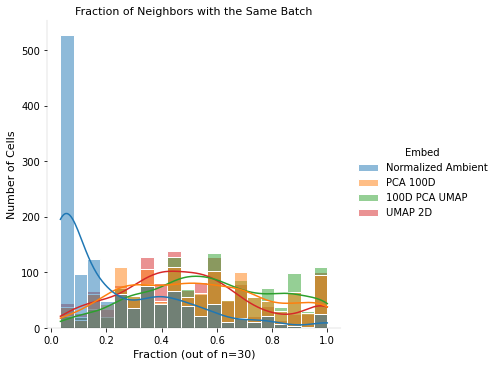

In [108]:
#celseq
plt.figure(figsize=(10,5))

integDF2 = integDF_mnn[integDF_mnn['Embed'].isin(['100D PCA UMAP','PCA 100D','Normalized Ambient','UMAP 2D'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('celseq_all.pdf')

<Figure size 720x360 with 0 Axes>

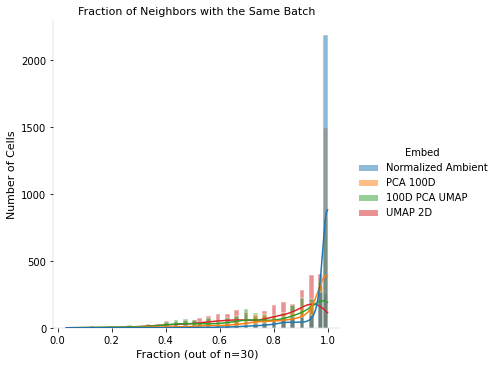

In [125]:
#smartseq
plt.figure(figsize=(10,5))

integDF2 = integDF_mnn[integDF_mnn['Embed'].isin(['100D PCA UMAP','PCA 100D','Normalized Ambient','UMAP 2D'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('smart_all.pdf')

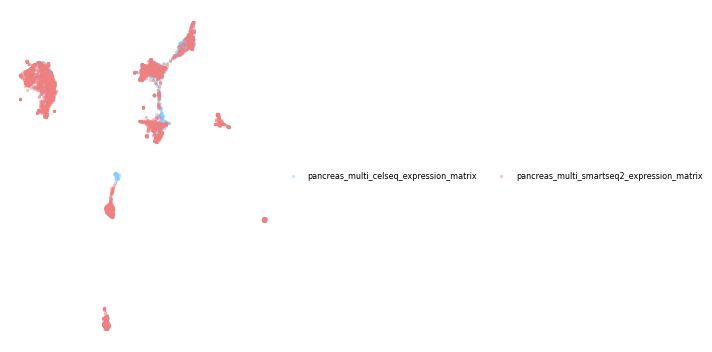

In [110]:
obj_plot_embed(pan_mnn_umap2d, np.array([i.replace('data/pancreas/','') for i in labels]), fname = 'stabUMAP.pdf',
               colors=['lightskyblue','lightcoral','darkseagreen'],figsize=(10,5))



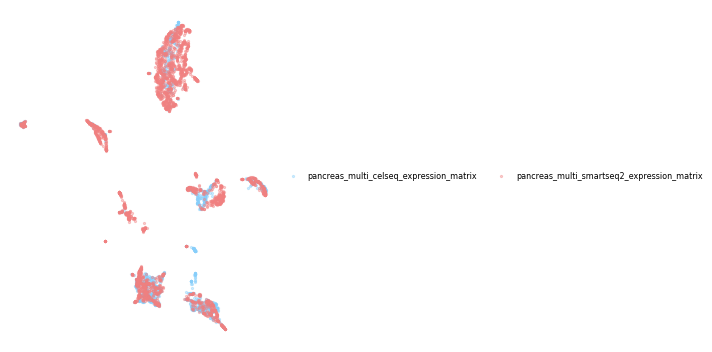

In [111]:
obj_plot_embed(pan_mnn_umap, np.array([i.replace('data/pancreas/','') for i in labels]), fname = 'panmnnUMAP.pdf',
               colors=['lightskyblue','lightcoral','darkseagreen'],figsize=(10,5))



Scanorama Output

In [127]:
#Calculations for scanorama - subset, 50/50 cells only
logNeigh, logClus = frac_unique_neighbors(np.asarray(pan_scan_scale), labels, spec_clus=ofinterest) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(pan_scan_pca), labels, spec_clus=ofinterest) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pan_scan_umap), labels, spec_clus=ofinterest) #pcaUMAP2 
umap2dNeigh, umap2dClus = frac_unique_neighbors(np.asarray(pan_scan_umap2d), labels, spec_clus=ofinterest) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(umap2dNeigh.values()),[]) ]
latent = ['Normalized Ambient','PCA 100D','100D PCA UMAP','UMAP 2D']

In [515]:
# #Calculations for scanorama
# logNeigh, logClus, logClus2 = frac_unique_neighbors(np.asarray(jurk_scan_scale), labels,cell_labels) #
# pcaNeigh, pcaClus, pcaClus2 = frac_unique_neighbors(np.asarray(jurk_scan_pca), labels,cell_labels) #pcaTSNE2
# umapNeigh, umapClus, umapClus2 = frac_unique_neighbors(np.asarray(jurk_scan_umap), labels,cell_labels) #pcaUMAP2 
# umap2dNeigh, umap2dClus, umap2dClus2 = frac_unique_neighbors(np.asarray(jurk_scan_umap2d), labels,cell_labels) #pcaUMAP2 


# latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(umap2dNeigh.values()),[]) ]
# latent = ['Normalized Ambient','PCA 100D','100D PCA UMAP','UMAP 2D']

In [128]:

integDF_scan = pd.DataFrame()
integDF_scan['Fraction'] = latents[0] + latents[1] + latents[2]+ latents[3]
integDF_scan['Embed'] = ['Normalized Ambient']*len(latents[0]) + ['PCA 100D']*len(latents[1]) + ['100D PCA UMAP']*len(latents[2]) + ['UMAP 2D']*len(latents[3])
integDF_scan.head()

,Fraction,Embed
0,1.000000,Normalized Ambient
1,1.000000,Normalized Ambient
2,1.000000,Normalized Ambient
3,0.933333,Normalized Ambient
4,1.000000,Normalized Ambient


In [129]:
print(statistics.mode(integDF_scan['Fraction'][integDF_scan['Embed'].isin(['Normalized Ambient'])]))
print(statistics.mode(integDF_scan['Fraction'][integDF_scan['Embed'].isin(['PCA 100D'])]))
print(statistics.mode(integDF_scan['Fraction'][integDF_scan['Embed'].isin(['100D PCA UMAP'])]))
print(statistics.mode(integDF_scan['Fraction'][integDF_scan['Embed'].isin(['UMAP 2D'])]))

1.0
1.0
1.0
1.0


<Figure size 720x360 with 0 Axes>

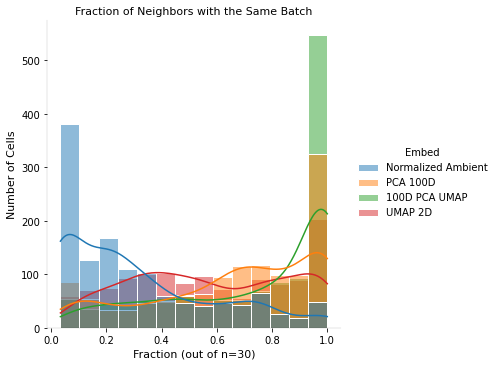

In [115]:
#celseq
plt.figure(figsize=(10,5))

integDF2 = integDF_scan[integDF_scan['Embed'].isin(['100D PCA UMAP','PCA 100D','Normalized Ambient','UMAP 2D'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('celseq_scano_all.pdf')

<Figure size 720x360 with 0 Axes>

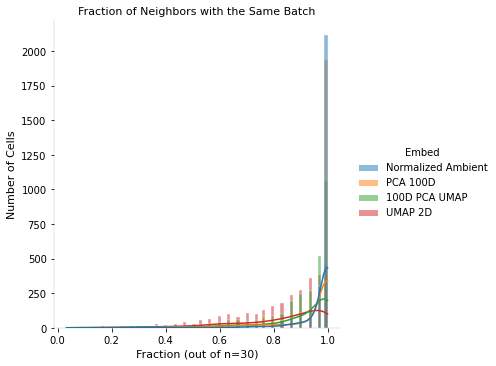

In [130]:
#smartseq
plt.figure(figsize=(10,5))

integDF2 = integDF_scan[integDF_scan['Embed'].isin(['100D PCA UMAP','PCA 100D','Normalized Ambient','UMAP 2D'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('smart_scano_all.pdf')

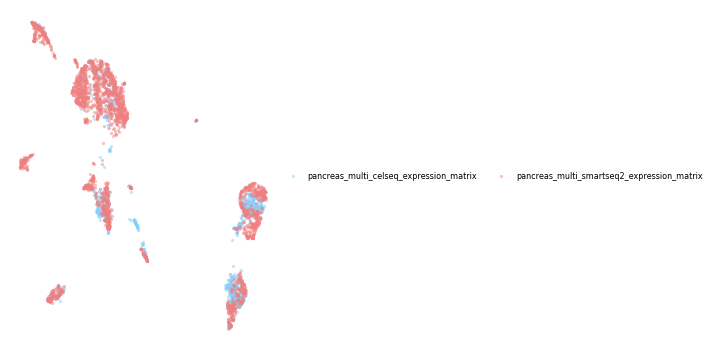

In [117]:
obj_plot_embed(pan_scan_umap2d, np.array([i.replace('data/pancreas/','') for i in labels]), fname = 'stabUMAP.pdf',
               colors=['lightskyblue','lightcoral','darkseagreen'],figsize=(10,5))



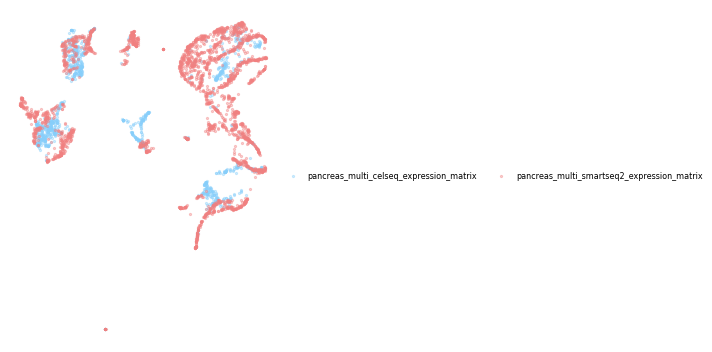

In [118]:
obj_plot_embed(pan_scan_umap, np.array([i.replace('data/pancreas/','') for i in labels]), fname = 'panscanoUMAP.pdf',
               colors=['lightskyblue','lightcoral','darkseagreen'],figsize=(10,5))



Compare to MNN

In [131]:
copy = integDF_mnn.copy()
copy['Embed'] = [i+'_MNN' for i in copy['Embed']]
integDF_both = pd.concat([integDF_scan,copy])

In [88]:
#For two datasets (smartseq and celseq, trends are flipped)

<Figure size 720x360 with 0 Axes>

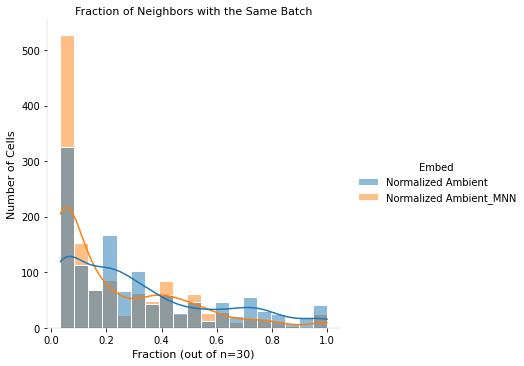

In [120]:
#celseq
plt.figure(figsize=(10,5))


integDF2 = integDF_both[integDF_both['Embed'].isin(['Normalized Ambient','Normalized Ambient_MNN'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('celseq_amb_comp.pdf')

<Figure size 720x360 with 0 Axes>

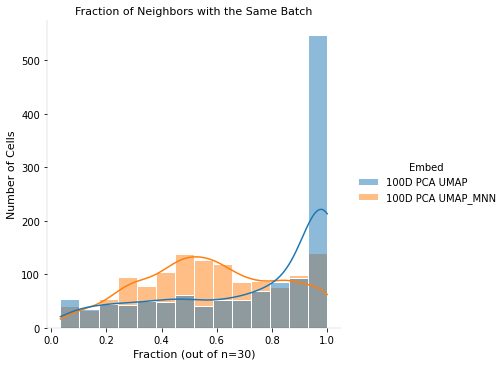

In [121]:
plt.figure(figsize=(10,5))


integDF2 = integDF_both[integDF_both['Embed'].isin(['100D PCA UMAP','100D PCA UMAP_MNN'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('celseq_2d_comp.pdf')


<Figure size 720x360 with 0 Axes>

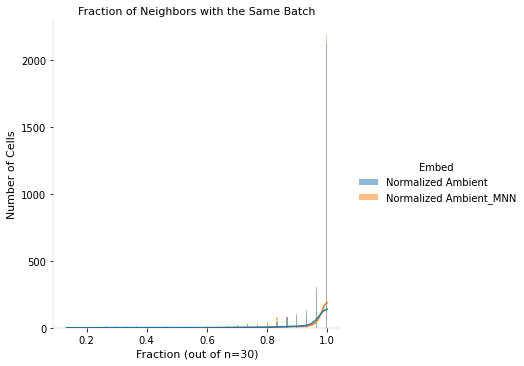

In [132]:
#smartseq
plt.figure(figsize=(10,5))


integDF2 = integDF_both[integDF_both['Embed'].isin(['Normalized Ambient','Normalized Ambient_MNN'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('smart_amb_comp.pdf')



<Figure size 720x360 with 0 Axes>

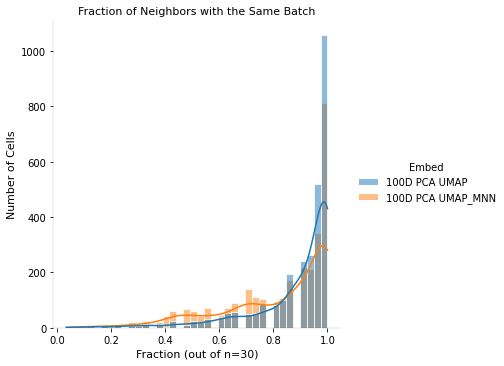

In [133]:
plt.figure(figsize=(10,5))


integDF2 = integDF_both[integDF_both['Embed'].isin(['100D PCA UMAP','100D PCA UMAP_MNN'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('smart_2d_comp.pdf')


Original Input

In [134]:
#Calculations for scanorama - subset, 50/50 cells only
logNeigh, logClus = frac_unique_neighbors(np.asarray(pan_orig_scale), labels, spec_clus=ofinterest) #
pcaNeigh, pcaClus = frac_unique_neighbors(np.asarray(pan_orig_pca), labels, spec_clus=ofinterest) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(np.asarray(pan_orig_umap), labels, spec_clus=ofinterest) #pcaUMAP2 
umap2dNeigh, umap2dClus = frac_unique_neighbors(np.asarray(pan_orig_umap2d), labels, spec_clus=ofinterest) #pcaUMAP2 


latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(umap2dNeigh.values()),[]) ]
latent = ['Normalized Ambient','PCA 100D','100D PCA UMAP','UMAP 2D']

In [82]:
# #Calculations for scanorama
# logNeigh, logClus, logClus2 = frac_unique_neighbors(np.asarray(jurk_orig_scale), labels,cell_labels) #
# pcaNeigh, pcaClus, pcaClus2 = frac_unique_neighbors(np.asarray(jurk_orig_pca), labels,cell_labels) #pcaTSNE2
# umapNeigh, umapClus, umapClus2 = frac_unique_neighbors(np.asarray(jurk_orig_umap), labels,cell_labels) #pcaUMAP2 
# umap2dNeigh, umap2dClus, umap2dClus2 = frac_unique_neighbors(np.asarray(jurk_orig_umap2d), labels,cell_labels) #pcaUMAP2 


# latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(umap2dNeigh.values()),[]) ]
# latent = ['Normalized Ambient','PCA 100D','100D PCA UMAP','UMAP 2D']

In [135]:

integDF_orig = pd.DataFrame()
integDF_orig['Fraction'] = latents[0] + latents[1] + latents[2]+ latents[3]
integDF_orig['Embed'] = ['Normalized Ambient']*len(latents[0]) + ['PCA 100D']*len(latents[1]) + ['100D PCA UMAP']*len(latents[2]) + ['UMAP 2D']*len(latents[3])
integDF_orig.head()

,Fraction,Embed
0,1.0,Normalized Ambient
1,1.0,Normalized Ambient
2,1.0,Normalized Ambient
3,1.0,Normalized Ambient
4,1.0,Normalized Ambient


In [136]:
print(statistics.mode(integDF_orig['Fraction'][integDF_orig['Embed'].isin(['Normalized Ambient'])]))
print(statistics.mode(integDF_orig['Fraction'][integDF_orig['Embed'].isin(['PCA 100D'])]))
print(statistics.mode(integDF_orig['Fraction'][integDF_orig['Embed'].isin(['100D PCA UMAP'])]))
print(statistics.mode(integDF_orig['Fraction'][integDF_orig['Embed'].isin(['UMAP 2D'])]))

1.0
1.0
1.0
1.0


<Figure size 720x360 with 0 Axes>

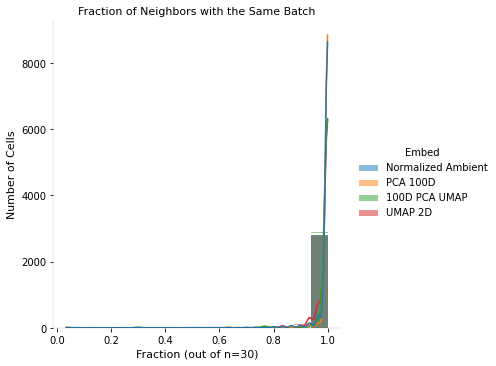

In [137]:
plt.figure(figsize=(10,5))

integDF2 = integDF_orig[integDF_orig['Embed'].isin(['100D PCA UMAP','PCA 100D','Normalized Ambient','UMAP 2D'])]
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.savefig('celseq_orig_all.pdf')


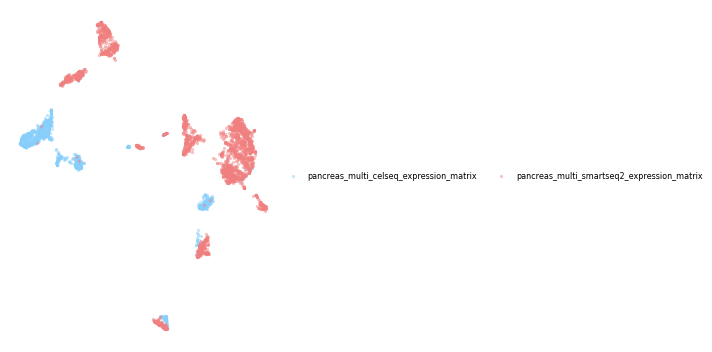

In [138]:
obj_plot_embed(pan_orig_umap2d, np.array([i.replace('data/pancreas/','') for i in labels]), fname = 'stabUMAP.pdf',
               colors=['lightskyblue','lightcoral','darkseagreen'],figsize=(10,5))



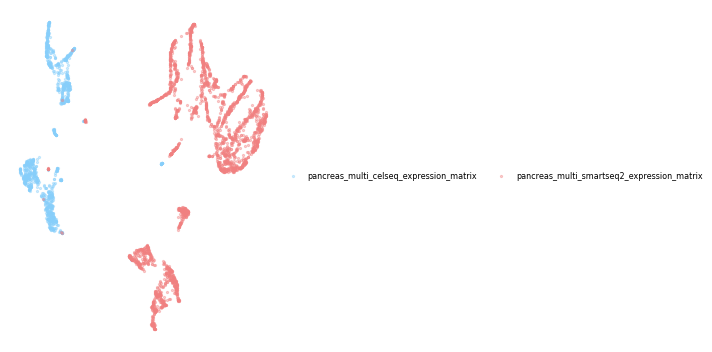

In [139]:
obj_plot_embed(pan_orig_umap, np.array([i.replace('data/pancreas/','') for i in labels]), fname = 'origUMAP.pdf',
               colors=['lightskyblue','lightcoral','darkseagreen'],figsize=(10,5))



In [140]:
copy_mnn = integDF_mnn.copy()
copy_scan = integDF_scan.copy()
copy_mnn['Embed'] = [i+'_MNN' for i in copy['Embed']]
copy_scan['Embed'] = [i+'_Scan' for i in copy_scan['Embed']]
integDF_all = pd.concat([copy_scan,copy,integDF_orig])

<Figure size 720x360 with 0 Axes>

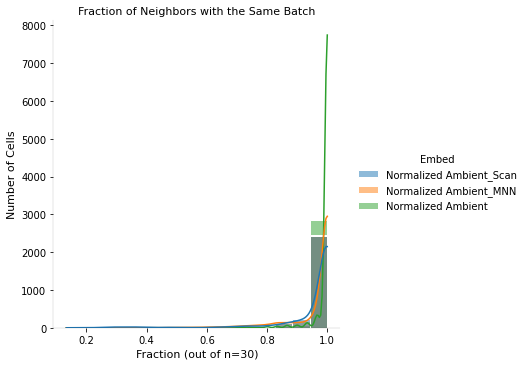

In [141]:
#celseq
plt.figure(figsize=(10,5))


integDF2 = integDF_all[integDF_all['Embed'].isin(['Normalized Ambient','Normalized Ambient_MNN',
                                                  'Normalized Ambient_Scan'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

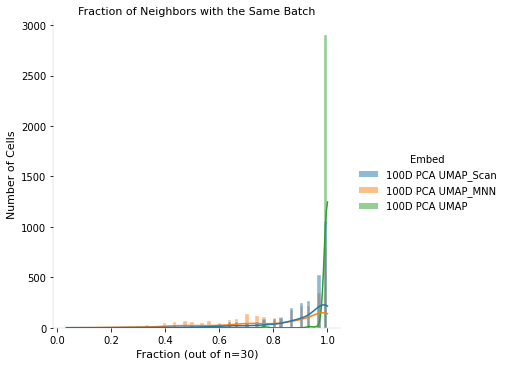

In [142]:
#celseq
plt.figure(figsize=(10,5))


integDF2 = integDF_all[integDF_all['Embed'].isin(['100D PCA UMAP','100D PCA UMAP_MNN','100D PCA UMAP_Scan'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

<Figure size 720x360 with 0 Axes>

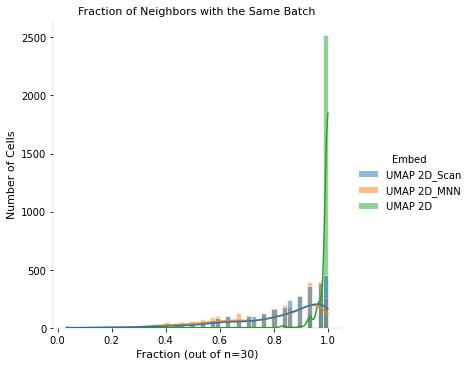

In [143]:
#celseq
plt.figure(figsize=(10,5))


integDF2 = integDF_all[integDF_all['Embed'].isin(['UMAP 2D','UMAP 2D_MNN','UMAP 2D_Scan'])]
integDF2 = integDF2.reset_index()
g=sns.displot(data=integDF2, x="Fraction", kde=True, hue='Embed',legend=True,edgecolor="white") #legend=False

#plt.legend(['PCA 30D UMAP','PCA 30D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Batch',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()